In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import scipy as sp
import mysql.connector
import os
import simplejson as json

## Import the libraries for modeling
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from autosklearn.regression import AutoSklearnRegressor

## Note concerning weather features

In [5]:
#### I included weather features in the initial testing of these models, and they were seen to be less predictive than simple time lags.
#### While weather features slightly improved the SVC and random forest models they did not push those models over the edge to become better than the linear regression model.
#### Furthermore, they did not improve the linear regression model enough to warrant the extra computation time needed for the heavier model.
#### Due to these reasons and for the sake of brevity I have left out the analyses with the weather features and only included those with time lags.

In [2]:
#### Gather historical data from the database so we don't have to make a bajillion calls while evaluating the model
## Get mysql credentials
mysql_host = os.getenv('JAWSDB_HOST')
mysql_username = os.getenv('JAWSDB_USERNAME')
mysql_password = os.getenv('JAWSDB_PASSWORD')
mysql_database = os.getenv('JAWSDB_DATABASE')

## Open database connection
mysqldb = mysql.connector.connect(host=mysql_host, user=mysql_username, passwd=mysql_password, db=mysql_database)
cur = mysqldb.cursor()

## Get station names
stations = []
cur.execute("SELECT `COLUMN_NAME` FROM `INFORMATION_SCHEMA`.`COLUMNS` WHERE `TABLE_SCHEMA`='"+str(mysql_database)+"' AND `TABLE_NAME`='station_availability';")
for entry in cur.fetchall():
    try:
        stations.append(int(entry[0]))
    except:
        continue

## Get timepoints and number of bikes at each station
cur.execute("SELECT * FROM station_availability;")
timepoints = []
values = []
for each in cur.fetchall():
    timepoints.append(each[0])
    values.append(each[1:])

## Create historical dataframe
df = pd.DataFrame(values, index = timepoints, columns = stations)
df.index = pd.to_datetime(df.index)
df.head()

,31000,31001,31002,31003,31004,31005,31006,31007,31008,31009,...,32217,32218,32219,32220,32221,32222,32223,32224,32225,31924
2017-06-11 16:50:00,2,3,14,10,9,10,1,3,3,3,...,5,6,7,4,8,7,5,6,8,NaN
2017-06-11 17:00:00,2,3,14,10,9,10,1,3,3,3,...,5,6,7,4,8,7,5,6,8,NaN
2017-06-11 17:10:00,2,3,14,10,9,10,1,3,3,3,...,5,6,7,4,8,7,5,6,8,NaN
2017-06-11 17:20:00,2,3,14,10,9,10,1,3,3,3,...,5,6,7,4,8,7,5,6,8,NaN
2017-06-11 17:30:00,1,3,11,9,9,14,0,7,3,3,...,5,6,7,4,8,7,5,6,8,NaN


In [3]:
#### Now let's set up our evaluation metric
#### Since we care more about whether or not a user will be able to get a bike rather than how many bikes/docks are at each station this is really a binary classification problem.
#### In order to have a more granular idea of how our model performs, however, we do still want to see how well our model predicts the number of bikes.
#### To this end we'll set up a regression model and use an eval metric to effectively make it a classification problem.
#### We can compare this to classifiers.
#### The classes will be determined by a cutoff of 2 bikes/docks or more representing a "yes."
#### Our evaluation metric will thus just be classification accuracy since the problem is such a simple one.
def eval_metric(preds, actual_values, cutoff):
    scores = []
    for i in range(len(preds)):
        if (preds[i] >= cutoff and actual_values[i] >= cutoff) or (preds[i] < cutoff and actual_values[i] < cutoff):
            scores.append(1)
        else:
            scores.append(0)
    return float(scores.count(1))/len(scores)

### Set up the regression model

Done with station 1 of 1 - 0:00:01.563359 since start.


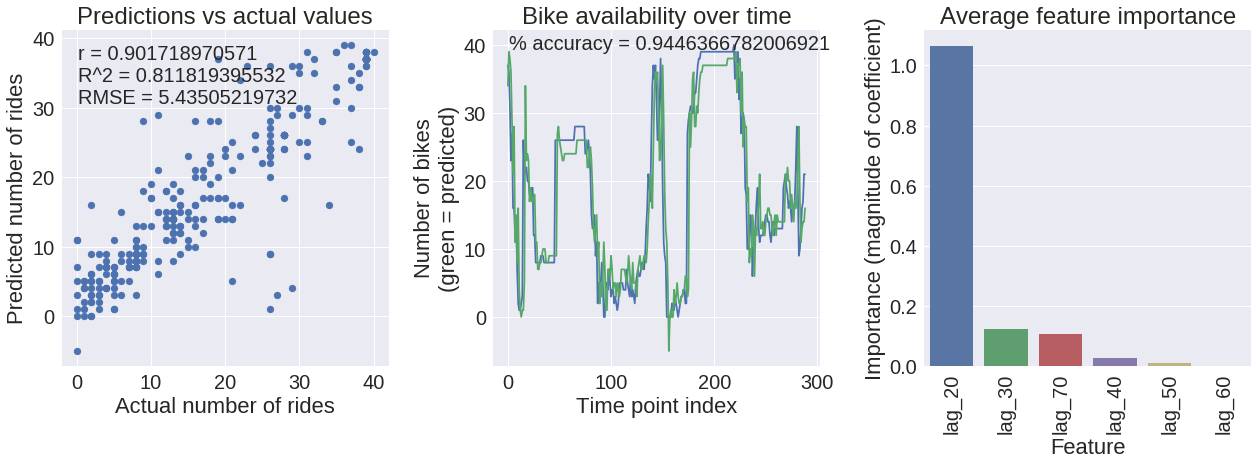

In [4]:
def makePrediction(time_to_predict, station, time_difference):
    ## Convert time_to_predict into datetime
    datetime_to_predict = pd.to_datetime(time_to_predict)

    ## Get data for training the model
    ## Make date range to get values for the day a week prior to the query
    ############## USE THIS FOR TESTING UNTIL ENOUGH DATA ARE ACQUIRED, THEN CHANGE FROM 1 DAY TO 7 DAYS PRIOR ####################
    start_time = datetime_to_predict - datetime.timedelta(hours = 24)
    end_time = datetime_to_predict

    ## Make container for data
    train_Xs = []
    train_ys = []
    ## Get data from the dataframe for a station between two times passed in as datetime objects.
    temp_df = pd.DataFrame(df[start_time:end_time][station])
    temp_df.columns = ['y']
            
    ## Make lag features
    number_of_lags = 6
    ## Add lags
    for i in range(1,number_of_lags+1):
        temp_df['lag_'+str(10*i+time_difference)] = temp_df.y.shift(int(i+time_difference/10))
    ## Drop NAs
    temp_df.dropna(inplace = True, axis = 0)
    ## Return X and y values
    temp_Xs = temp_df.drop('y', axis = 1)
    temp_ys = temp_df.y

    ## Get data for making the prediction
    train_Xs = temp_Xs.iloc[:-1, :]
    train_ys = temp_ys.iloc[:-1]
    test_Xs = temp_Xs.iloc[-1, :]
    test_y = temp_ys.iloc[-1]
    
    features = train_Xs.columns
    
    ## Make a linear regression and train it on the previous day
    lr = LinearRegression()
    lr.fit(train_Xs, train_ys)
    ## Make a prediction for the time in question
    prediction = int(np.round(lr.predict(np.array(test_Xs).reshape(1,-1))))
    ## return the prediction and the actual value
    return prediction, test_y, lr, features

def makePlot(preds, actual_vals, coefs_list, feature_names):
    ## Convert the list of arrays each with a single value to a list of values
    lr_variance = r2_score(actual_vals, preds)
    lr_rmse = np.sqrt(mean_squared_error(actual_vals, preds))
    lr_r = sp.stats.pearsonr(actual_vals, preds)[0]

    sns.set(font_scale = 2)
    fig = plt.figure(figsize = [18, 7])
    plt.subplot(1,3,1)
    plt.scatter(actual_vals, preds)
    plt.title('Predictions vs actual values')
    plt.ylabel('Predicted number of rides')
    plt.xlabel('Actual number of rides')
    plt.annotate('r = '+str(sp.stats.pearsonr(actual_vals, preds)[0])+"\nR^2 = "+str(lr_variance)+"\nRMSE = "+str(lr_rmse), xy=(0.05, 0.78), xycoords='axes fraction', size = 20)
    plt.tight_layout()
    plt.subplot(1,3,2)
    plt.plot(actual_vals)
    plt.plot(preds)
    plt.title('Bike availability over time')
    plt.xlabel('Time point index')
    plt.ylabel('Number of bikes\n(green = predicted)')
    plt.annotate('% accuracy = '+str(eval_metric(actual_vals, preds,2)), xy=(0.05, 0.94), xycoords='axes fraction', size = 20)
    plt.subplot(1,3,3)
    coefs = pd.DataFrame([(x,y) for (y,x) in sorted(list(zip(np.abs(np.mean(np.array(coefs_list), axis = 0)), feature_names))[:], reverse = True)], 
                         columns = ['Feature', 'Importance (magnitude of coefficient)'])
    sns.barplot(x = 'Feature', y = 'Importance (magnitude of coefficient)', data = coefs)
    plt.xticks(rotation=90)
    plt.title('Average feature importance')
    plt.ylabel('Importance (magnitude of coefficient)')
    plt.tight_layout()

## Give a start time for predictions
start_time_to_predict = '2017-06-12 17:00'
## Give an end time for predictions
end_time_to_predict = '2017-06-14 17:00'
## Make a date range of dates to predict
date_range = pd.date_range(start = pd.to_datetime(start_time_to_predict), end = pd.to_datetime(end_time_to_predict), freq = '10min')
## Make a list of stations for which to make predictions (or just predict all in stations from before)
# stations_to_predict = [31623, 31304, 31520, 31242, 31207, 31204, 31635, 31019, 31919, 31047, 31004]
stations_to_predict = [31623]
## Make various time diffs
time_diffs = [10*i for i in range(1,2)]

## Make containers for relevant values for evaluation
predictions = []
test_ys = []
coefs_list = []
## Make a prediction for various stations
init_time = datetime.datetime.now()
for i, prediction_station in enumerate(stations_to_predict):
    temp_dict = {}
    ## Make a prediction for a range of time diffs
    for prediction_time_diff in time_diffs:
        ## Make a prediction for each time in the date range
        for prediction_time in date_range:
            pred, actual_value, lr, features = makePrediction(prediction_time, prediction_station, prediction_time_diff)
            predictions.append(pred)
            test_ys.append(actual_value)
            coefs_list.append(lr.coef_)
    print('Done with station', i+1, 'of', len(stations_to_predict), '-', datetime.datetime.now() - init_time, 'since start.')

makePlot(predictions, test_ys, coefs_list, features)

### Set up the classifier

In [5]:
## Make the data sets
def makeData(time_to_predict, station, time_difference):
    ## Convert time_to_predict into datetime
    datetime_to_predict = pd.to_datetime(time_to_predict)

    ## Get data for training the model
    ## Make date range to get values for the day a week prior to the query
    ############## USE THIS FOR TESTING UNTIL ENOUGH DATA ARE ACQUIRED, THEN CHANGE FROM 1 DAY TO 7 DAYS PRIOR ####################
    start_time = datetime_to_predict - datetime.timedelta(hours = 24)
    end_time = datetime_to_predict

    ## Make container for data
    train_Xs = []
    train_ys = []
    ## Get data from the dataframe for a station between two times passed in as datetime objects.
    temp_df = pd.DataFrame(df[start_time:end_time][station])
    temp_df.columns = ['y']
            
    ## Make lag features
    number_of_lags = 6
    ## Add lags
    for i in range(1,number_of_lags+1):
        temp_df['lag_'+str(10*i+time_difference)] = temp_df.y.shift(int(i+time_difference/10))
    ## Drop NAs
    temp_df.dropna(inplace = True, axis = 0)
    ## Return X and y values
    temp_Xs = temp_df.drop('y', axis = 1)
    temp_ys = temp_df.y
    temp_ys.loc[temp_ys < 2] = 0
    temp_ys.loc[temp_ys >= 2] = 1

    ## Get data for making the prediction
    train_Xs = temp_Xs.iloc[:-1, :]
    train_ys = temp_ys.iloc[:-1]
    test_Xs = temp_Xs.iloc[-1, :]
    test_y = temp_ys.iloc[-1]
        
    return train_Xs, train_ys, test_Xs, test_y

train_Xs, train_ys, test_Xs, test_y = makeData('2017-06-16 16:00', 31623, 10)

X_train = np.ascontiguousarray(train_Xs)
y_train = np.ascontiguousarray(train_ys)
X_test = np.ascontiguousarray(test_Xs)
y_test = np.ascontiguousarray(test_y)

In [7]:
## Let's try a simple SVC model to take care of the logistic regression case as well as some other kernels
## First let's find hyperparameters
## A GridSearchCV isn't going to work well due to the inability for sklearnn to automatically make a time series cv object for this specific dataset.
## TimeSeriesSplit will end up splitting the data into folds where some only have one class (1 or 0), and it will throw an error.
## We will thus make our own grid search with our own validation that is the same procedure as we used for the linear regression previously.
## Parameters we care about are C and kernel
C = [1e-2, 1e-1, 1, 3]
kernel = ['linear', 'rbf', 'sigmoid', 'poly']

## Give a start time for predictions
start_time_to_predict = '2017-06-12 17:00'
## Give an end time for predictions
end_time_to_predict = '2017-06-14 17:00'
## Make a date range of dates to predict
date_range = pd.date_range(start = pd.to_datetime(start_time_to_predict), end = pd.to_datetime(end_time_to_predict), freq = '10min')
## Make a list of stations for which to make predictions (or just predict all in stations from before)
# stations_to_predict = [31623, 31304, 31520, 31242, 31207, 31204, 31635, 31019, 31919, 31047, 31004]
stations_to_predict = [31623]
## Make various time diffs
time_diffs = [10*i for i in range(1,2)]

init_time = datetime.datetime.now()
for kernel_param in kernel:
    for C_param in C:
        ## Make containers for relevant values for evaluation
        predictions = []
        test_ys = []
        coefs_list = []
        acc_scores = []
        ## Make a prediction for various stations
        for prediction_time_diff in time_diffs:
            ## Make a prediction for each time in the date range
            for i, prediction_station in enumerate(stations_to_predict):
                ## Make a prediction for a range of time diffs
                for prediction_time in date_range:
                    try:
                        train_Xs, train_ys, test_Xs, test_y = makeData(prediction_time, prediction_station, prediction_time_diff)
                        svc = SVC(random_state = 1, class_weight='balanced', decision_function_shape='ovr', C = C_param, kernel = kernel_param)
                        svc.fit(train_Xs, train_ys)
                        pred = svc.predict(test_Xs.values.reshape(1,-1))
                        predictions.append(pred)
                        test_ys.append(test_y)
                    except:
                        continue
            acc_score = accuracy_score(test_ys, predictions)
            acc_scores.append(acc_score)
            print('Accuracy score for kernel =', kernel_param, '| C =',C_param, ' =', acc_score, '|||', datetime.datetime.now() - init_time, 'since start...')

Accuracy score for kernel = linear | C = 0.01  = 0.799307958478 ||| 0:00:19.063916 since start...
Accuracy score for kernel = linear | C = 0.1  = 0.837370242215 ||| 0:00:38.067987 since start...
Accuracy score for kernel = linear | C = 1  = 0.847750865052 ||| 0:00:57.710729 since start...
Accuracy score for kernel = linear | C = 3  = 0.847750865052 ||| 0:01:17.660028 since start...
Accuracy score for kernel = rbf | C = 0.01  = 0.539792387543 ||| 0:01:36.788123 since start...
Accuracy score for kernel = rbf | C = 0.1  = 0.43598615917 ||| 0:01:55.949038 since start...
Accuracy score for kernel = rbf | C = 1  = 0.930795847751 ||| 0:02:15.225855 since start...
Accuracy score for kernel = rbf | C = 3  = 0.937716262976 ||| 0:02:34.355968 since start...
Accuracy score for kernel = sigmoid | C = 0.01  = 0.356401384083 ||| 0:02:53.776873 since start...
Accuracy score for kernel = sigmoid | C = 0.1  = 0.425605536332 ||| 0:03:12.872168 since start...
Accuracy score for kernel = sigmoid | C = 1  =

In [8]:
## Meh, the results for the SVC are comparable to our linear regression-based classifier, but the SVC takes a lot longer (~1 second versus ~20 seconds)
## Since we don't want the user to have to wait for the result when they click the "plan route" button speed is of paramount importance.
## We'll try a random forest just for kicks and leave it going overnight since it's likely going to take forever to grid search.
## It's speed will also be very slow compare to the linear regression, so this really is just for fun.

### Set up the random forest classifier

In [6]:
## Same situation as before with the grid search and the cv problems
## We will make our own grid search with our own validation that is the same procedure as we used for the linear regression previously.
## Parameters we care about are n_estimators, max_depth, max_features, min_samples_split, min_samples_leaf, min_weight_fraction_leaf, max_leaf_nodes
n_estimators = [10, 100]
max_depth = [6, 10]
max_features = [6]
min_samples_split = [3, 6, 9]
min_samples_leaf = [3, 6, 9]
min_weight_fraction_leaf = [0, 0.25, 0.5]
max_leaf_nodes = [5, 10, 15]

## Give a start time for predictions
start_time_to_predict = '2017-06-12 17:00'
## Give an end time for predictions
end_time_to_predict = '2017-06-14 17:00'
## Make a date range of dates to predict
date_range = pd.date_range(start = pd.to_datetime(start_time_to_predict), end = pd.to_datetime(end_time_to_predict), freq = '10min')
## Make a list of stations for which to make predictions (or just predict all in stations from before)
# stations_to_predict = [31623, 31304, 31520, 31242, 31207, 31204, 31635, 31019, 31919, 31047, 31004]
stations_to_predict = [31623]
## Make various time diffs
time_diffs = [10*i for i in range(1,2)]

init_time = datetime.datetime.now()
for n_estimators_param in n_estimators:
    for max_depth_param in max_depth:
        for max_features_param in max_features:
            for min_samples_split_param in min_samples_split:
                for min_samples_leaf_param in min_samples_leaf:
                    for min_weight_fraction_leaf_param in min_weight_fraction_leaf:
                        for max_leaf_nodes_param in max_leaf_nodes:
                            ## Make containers for relevant values for evaluation
                            predictions = []
                            test_ys = []
                            coefs_list = []
                            acc_scores = []
                            ## Make a prediction for various stations
                            for prediction_time_diff in time_diffs:
                                ## Make a prediction for each time in the date range
                                for i, prediction_station in enumerate(stations_to_predict):
                                    ## Make a prediction for a range of time diffs
                                    for prediction_time in date_range:
                                        try:
                                            train_Xs, train_ys, test_Xs, test_y = makeData(prediction_time, prediction_station, prediction_time_diff)
                                            rfc = RandomForestClassifier(random_state = 1, class_weight='balanced', n_jobs = 8, max_depth = max_depth_param, max_features = max_features_param,
                                                                         min_samples_split = min_samples_split_param, min_samples_leaf = min_samples_leaf_param, 
                                                                         min_weight_fraction_leaf = min_weight_fraction_leaf_param, max_leaf_nodes = max_leaf_nodes_param) 
                                            rfc.fit(train_Xs, train_ys)
                                            pred = rfc.predict(test_Xs.values.reshape(1,-1))
                                            predictions.append(pred)
                                            test_ys.append(test_y)
                                        except:
                                            print('THIS ONE DIDNT WORK: n_estimators =', n_estimators_param, '| max_depth =', max_depth_param, '| max_features =', max_features_param, 
                                                  '| min_samples_split', min_samples_split_param, '| min_samples_leaf', min_samples_leaf_param, "| min_weight_fraction_leaf", 
                                                  min_weight_fraction_leaf_param, '| max_leaf_nodes', max_leaf_nodes_param, '|||', datetime.datetime.now() - init_time, 'since start...')
                                            continue
                                acc_score = accuracy_score(test_ys, predictions)
                                acc_scores.append(acc_score)
                                print('Accuracy score for n_estimators =', n_estimators_param, '| max_depth =', max_depth_param, '| max_features =', max_features_param, 
                                      '| min_samples_split', min_samples_split_param, '| min_samples_leaf', min_samples_leaf_param, "| min_weight_fraction_leaf", 
                                      min_weight_fraction_leaf_param, '| max_leaf_nodes', max_leaf_nodes_param, '| accuracy =', acc_score, '|||', datetime.datetime.now() - init_time, 'since start...')

Accuracy score for n_estimators = 10 | max_depth = 6 | max_features = 6 | min_samples_split 3 | min_samples_leaf 3 | min_weight_fraction_leaf 0 | max_leaf_nodes 5 | accuracy = 0.882352941176 ||| 0:01:19.116112 since start...
Accuracy score for n_estimators = 10 | max_depth = 6 | max_features = 6 | min_samples_split 3 | min_samples_leaf 3 | min_weight_fraction_leaf 0 | max_leaf_nodes 10 | accuracy = 0.906574394464 ||| 0:02:38.099951 since start...
Accuracy score for n_estimators = 10 | max_depth = 6 | max_features = 6 | min_samples_split 3 | min_samples_leaf 3 | min_weight_fraction_leaf 0 | max_leaf_nodes 15 | accuracy = 0.906574394464 ||| 0:03:57.187100 since start...
Accuracy score for n_estimators = 10 | max_depth = 6 | max_features = 6 | min_samples_split 3 | min_samples_leaf 3 | min_weight_fraction_leaf 0.25 | max_leaf_nodes 5 | accuracy = 0.826989619377 ||| 0:05:16.164392 since start...
Accuracy score for n_estimators = 10 | max_depth = 6 | max_features = 6 | min_samples_split 3 |

Accuracy score for n_estimators = 10 | max_depth = 6 | max_features = 6 | min_samples_split 6 | min_samples_leaf 6 | min_weight_fraction_leaf 0 | max_leaf_nodes 10 | accuracy = 0.889273356401 ||| 0:50:34.318824 since start...
Accuracy score for n_estimators = 10 | max_depth = 6 | max_features = 6 | min_samples_split 6 | min_samples_leaf 6 | min_weight_fraction_leaf 0 | max_leaf_nodes 15 | accuracy = 0.889273356401 ||| 0:51:54.254663 since start...
Accuracy score for n_estimators = 10 | max_depth = 6 | max_features = 6 | min_samples_split 6 | min_samples_leaf 6 | min_weight_fraction_leaf 0.25 | max_leaf_nodes 5 | accuracy = 0.809688581315 ||| 0:53:14.150609 since start...
Accuracy score for n_estimators = 10 | max_depth = 6 | max_features = 6 | min_samples_split 6 | min_samples_leaf 6 | min_weight_fraction_leaf 0.25 | max_leaf_nodes 10 | accuracy = 0.809688581315 ||| 0:54:35.614204 since start...
Accuracy score for n_estimators = 10 | max_depth = 6 | max_features = 6 | min_samples_split

Accuracy score for n_estimators = 10 | max_depth = 6 | max_features = 6 | min_samples_split 9 | min_samples_leaf 9 | min_weight_fraction_leaf 0 | max_leaf_nodes 15 | accuracy = 0.847750865052 ||| 1:40:25.728773 since start...
Accuracy score for n_estimators = 10 | max_depth = 6 | max_features = 6 | min_samples_split 9 | min_samples_leaf 9 | min_weight_fraction_leaf 0.25 | max_leaf_nodes 5 | accuracy = 0.799307958478 ||| 1:41:45.786341 since start...
Accuracy score for n_estimators = 10 | max_depth = 6 | max_features = 6 | min_samples_split 9 | min_samples_leaf 9 | min_weight_fraction_leaf 0.25 | max_leaf_nodes 10 | accuracy = 0.799307958478 ||| 1:43:05.838313 since start...
Accuracy score for n_estimators = 10 | max_depth = 6 | max_features = 6 | min_samples_split 9 | min_samples_leaf 9 | min_weight_fraction_leaf 0.25 | max_leaf_nodes 15 | accuracy = 0.799307958478 ||| 1:44:25.874820 since start...
Accuracy score for n_estimators = 10 | max_depth = 6 | max_features = 6 | min_samples_sp

Accuracy score for n_estimators = 10 | max_depth = 10 | max_features = 6 | min_samples_split 6 | min_samples_leaf 3 | min_weight_fraction_leaf 0 | max_leaf_nodes 15 | accuracy = 0.906574394464 ||| 2:28:16.125773 since start...
Accuracy score for n_estimators = 10 | max_depth = 10 | max_features = 6 | min_samples_split 6 | min_samples_leaf 3 | min_weight_fraction_leaf 0.25 | max_leaf_nodes 5 | accuracy = 0.826989619377 ||| 2:29:35.112207 since start...
Accuracy score for n_estimators = 10 | max_depth = 10 | max_features = 6 | min_samples_split 6 | min_samples_leaf 3 | min_weight_fraction_leaf 0.25 | max_leaf_nodes 10 | accuracy = 0.826989619377 ||| 2:30:53.948463 since start...
Accuracy score for n_estimators = 10 | max_depth = 10 | max_features = 6 | min_samples_split 6 | min_samples_leaf 3 | min_weight_fraction_leaf 0.25 | max_leaf_nodes 15 | accuracy = 0.826989619377 ||| 2:32:12.950251 since start...
Accuracy score for n_estimators = 10 | max_depth = 10 | max_features = 6 | min_sampl

Accuracy score for n_estimators = 10 | max_depth = 10 | max_features = 6 | min_samples_split 9 | min_samples_leaf 6 | min_weight_fraction_leaf 0 | max_leaf_nodes 15 | accuracy = 0.889273356401 ||| 3:15:39.056943 since start...
Accuracy score for n_estimators = 10 | max_depth = 10 | max_features = 6 | min_samples_split 9 | min_samples_leaf 6 | min_weight_fraction_leaf 0.25 | max_leaf_nodes 5 | accuracy = 0.809688581315 ||| 3:17:00.158410 since start...
Accuracy score for n_estimators = 10 | max_depth = 10 | max_features = 6 | min_samples_split 9 | min_samples_leaf 6 | min_weight_fraction_leaf 0.25 | max_leaf_nodes 10 | accuracy = 0.809688581315 ||| 3:18:20.554869 since start...
Accuracy score for n_estimators = 10 | max_depth = 10 | max_features = 6 | min_samples_split 9 | min_samples_leaf 6 | min_weight_fraction_leaf 0.25 | max_leaf_nodes 15 | accuracy = 0.809688581315 ||| 3:19:40.822950 since start...
Accuracy score for n_estimators = 10 | max_depth = 10 | max_features = 6 | min_sampl

Accuracy score for n_estimators = 100 | max_depth = 6 | max_features = 6 | min_samples_split 3 | min_samples_leaf 9 | min_weight_fraction_leaf 0 | max_leaf_nodes 15 | accuracy = 0.847750865052 ||| 4:03:20.529663 since start...
Accuracy score for n_estimators = 100 | max_depth = 6 | max_features = 6 | min_samples_split 3 | min_samples_leaf 9 | min_weight_fraction_leaf 0.25 | max_leaf_nodes 5 | accuracy = 0.799307958478 ||| 4:04:39.366851 since start...
Accuracy score for n_estimators = 100 | max_depth = 6 | max_features = 6 | min_samples_split 3 | min_samples_leaf 9 | min_weight_fraction_leaf 0.25 | max_leaf_nodes 10 | accuracy = 0.799307958478 ||| 4:05:58.318576 since start...
Accuracy score for n_estimators = 100 | max_depth = 6 | max_features = 6 | min_samples_split 3 | min_samples_leaf 9 | min_weight_fraction_leaf 0.25 | max_leaf_nodes 15 | accuracy = 0.799307958478 ||| 4:07:17.267193 since start...
Accuracy score for n_estimators = 100 | max_depth = 6 | max_features = 6 | min_sampl

Accuracy score for n_estimators = 100 | max_depth = 6 | max_features = 6 | min_samples_split 9 | min_samples_leaf 3 | min_weight_fraction_leaf 0 | max_leaf_nodes 15 | accuracy = 0.899653979239 ||| 4:50:42.600717 since start...
Accuracy score for n_estimators = 100 | max_depth = 6 | max_features = 6 | min_samples_split 9 | min_samples_leaf 3 | min_weight_fraction_leaf 0.25 | max_leaf_nodes 5 | accuracy = 0.826989619377 ||| 4:52:01.588751 since start...
Accuracy score for n_estimators = 100 | max_depth = 6 | max_features = 6 | min_samples_split 9 | min_samples_leaf 3 | min_weight_fraction_leaf 0.25 | max_leaf_nodes 10 | accuracy = 0.826989619377 ||| 4:53:20.548922 since start...
Accuracy score for n_estimators = 100 | max_depth = 6 | max_features = 6 | min_samples_split 9 | min_samples_leaf 3 | min_weight_fraction_leaf 0.25 | max_leaf_nodes 15 | accuracy = 0.826989619377 ||| 4:54:39.402890 since start...
Accuracy score for n_estimators = 100 | max_depth = 6 | max_features = 6 | min_sampl

Accuracy score for n_estimators = 100 | max_depth = 10 | max_features = 6 | min_samples_split 3 | min_samples_leaf 6 | min_weight_fraction_leaf 0 | max_leaf_nodes 15 | accuracy = 0.889273356401 ||| 5:38:04.678357 since start...
Accuracy score for n_estimators = 100 | max_depth = 10 | max_features = 6 | min_samples_split 3 | min_samples_leaf 6 | min_weight_fraction_leaf 0.25 | max_leaf_nodes 5 | accuracy = 0.809688581315 ||| 5:39:23.643194 since start...
Accuracy score for n_estimators = 100 | max_depth = 10 | max_features = 6 | min_samples_split 3 | min_samples_leaf 6 | min_weight_fraction_leaf 0.25 | max_leaf_nodes 10 | accuracy = 0.809688581315 ||| 5:40:42.464556 since start...
Accuracy score for n_estimators = 100 | max_depth = 10 | max_features = 6 | min_samples_split 3 | min_samples_leaf 6 | min_weight_fraction_leaf 0.25 | max_leaf_nodes 15 | accuracy = 0.809688581315 ||| 5:42:01.428974 since start...
Accuracy score for n_estimators = 100 | max_depth = 10 | max_features = 6 | min_

Accuracy score for n_estimators = 100 | max_depth = 10 | max_features = 6 | min_samples_split 6 | min_samples_leaf 9 | min_weight_fraction_leaf 0 | max_leaf_nodes 15 | accuracy = 0.847750865052 ||| 6:25:26.941971 since start...
Accuracy score for n_estimators = 100 | max_depth = 10 | max_features = 6 | min_samples_split 6 | min_samples_leaf 9 | min_weight_fraction_leaf 0.25 | max_leaf_nodes 5 | accuracy = 0.799307958478 ||| 6:26:45.749190 since start...
Accuracy score for n_estimators = 100 | max_depth = 10 | max_features = 6 | min_samples_split 6 | min_samples_leaf 9 | min_weight_fraction_leaf 0.25 | max_leaf_nodes 10 | accuracy = 0.799307958478 ||| 6:28:04.729628 since start...
Accuracy score for n_estimators = 100 | max_depth = 10 | max_features = 6 | min_samples_split 6 | min_samples_leaf 9 | min_weight_fraction_leaf 0.25 | max_leaf_nodes 15 | accuracy = 0.799307958478 ||| 6:29:23.732706 since start...
Accuracy score for n_estimators = 100 | max_depth = 10 | max_features = 6 | min_

In [ ]:
## As predicted the random forest model did similarly on accuracy for some parameter combinations but took forever to run compared to the linear regression.

In [32]:
## Let's just do a simple auto-sklearn regressor to see if we can improve upon the regression strategy without losing much speed.
## Make the data sets
def makeRegressorData(time_to_predict, station, time_difference):
    ## Convert time_to_predict into datetime
    datetime_to_predict = pd.to_datetime(time_to_predict)

    ## Get data for training the model
    ## Make date range to get values for the day a week prior to the query
    ############## USE THIS FOR TESTING UNTIL ENOUGH DATA ARE ACQUIRED, THEN CHANGE FROM 1 DAY TO 7 DAYS PRIOR ####################
    start_time = datetime_to_predict - datetime.timedelta(hours = 24)
    end_time = datetime_to_predict

    ## Make container for data
    train_Xs = []
    train_ys = []
    ## Get data from the dataframe for a station between two times passed in as datetime objects.
    temp_df = pd.DataFrame(df[start_time:end_time][station])
    temp_df.columns = ['y']
            
    ## Make lag features
    number_of_lags = 6
    ## Add lags
    for i in range(1,number_of_lags+1):
        temp_df['lag_'+str(10*i+time_difference)] = temp_df.y.shift(int(i+time_difference/10))
    ## Drop NAs
    temp_df.dropna(inplace = True, axis = 0)
    ## Return X and y values
    temp_Xs = temp_df.drop('y', axis = 1)
    temp_ys = temp_df.y

    ## Get data for making the prediction
    train_Xs = temp_Xs.iloc[:-1, :]
    train_ys = temp_ys.iloc[:-1]
    test_Xs = temp_Xs.iloc[-1, :]
    test_y = temp_ys.iloc[-1]
        
    return train_Xs, train_ys, test_Xs, test_y

train_Xs, train_ys, test_Xs, test_y = makeRegressorData('2017-06-16 16:00', 31623, 10)

X_train = np.ascontiguousarray(train_Xs)
y_train = np.ascontiguousarray(train_ys)
X_test = np.ascontiguousarray(test_Xs)
y_test = np.ascontiguousarray(test_y)

automl = AutoSklearnRegressor(time_left_for_this_task=3600, per_run_time_limit=360, ml_memory_limit=16384)
automl.fit(X_train, y_train)

[WARNING] [2017-06-17 12:46:07,517:AutoMLSMBO(1)::1c0cf9cf879c164af66733d2f50416cf] Could not find meta-data directory /usr/lib64/python3.5/site-packages/autosklearn/metalearning/files/r2_regression_dense


You are already timing task: index_run6
You are already timing task: index_run10
You are already timing task: index_run10
You are already timing task: index_run11


[WARNING] [2017-06-17 12:48:33,592:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2017-06-17 12:48:33,592:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger


You are already timing task: index_run11
You are already timing task: index_run11
You are already timing task: index_run11
You are already timing task: index_run11
You are already timing task: index_run11
You are already timing task: index_run11
You are already timing task: index_run11
You are already timing task: index_run11
You are already timing task: index_run11
You are already timing task: index_run11
You are already timing task: index_run12
You are already timing task: index_run13


[WARNING] [2017-06-17 12:49:07,014:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2017-06-17 12:49:07,014:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger


You are already timing task: index_run13
You are already timing task: index_run13
You are already timing task: index_run13
You are already timing task: index_run13
You are already timing task: index_run14
You are already timing task: index_run14
You are already timing task: index_run14
You are already timing task: index_run14
You are already timing task: index_run17
You are already timing task: index_run19
You are already timing task: index_run20
You are already timing task: index_run20
You are already timing task: index_run20
You are already timing task: index_run20
You are already timing task: index_run20
You are already timing task: index_run21
You are already timing task: index_run21
You are already timing task: index_run21
You are already timing task: index_run21
You are already timing task: index_run22
You are already timing task: index_run22
You are already timing task: index_run22
You are already timing task: index_run22
You are already timing task: index_run22
You are already 

[WARNING] [2017-06-17 12:58:31,467:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2017-06-17 12:58:31,467:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger


You are already timing task: index_run34
You are already timing task: index_run34
You are already timing task: index_run34
You are already timing task: index_run34
You are already timing task: index_run34
You are already timing task: index_run34
You are already timing task: index_run34
You are already timing task: index_run34
You are already timing task: index_run34
You are already timing task: index_run35
You are already timing task: index_run35
You are already timing task: index_run35
You are already timing task: index_run35
You are already timing task: index_run35
You are already timing task: index_run35
You are already timing task: index_run35
You are already timing task: index_run35
You are already timing task: index_run35
You are already timing task: index_run35
You are already timing task: index_run36
You are already timing task: index_run36
You are already timing task: index_run36
You are already timing task: index_run36
You are already timing task: index_run36
You are already 

You are already timing task: index_run42
You are already timing task: index_run42
You are already timing task: index_run42
You are already timing task: index_run42
You are already timing task: index_run42
You are already timing task: index_run42
You are already timing task: index_run42
You are already timing task: index_run42
You are already timing task: index_run42
You are already timing task: index_run42
You are already timing task: index_run42
You are already timing task: index_run42
You are already timing task: index_run42
You are already timing task: index_run42
You are already timing task: index_run42
You are already timing task: index_run42
You are already timing task: index_run42
You are already timing task: index_run42
You are already timing task: index_run42
You are already timing task: index_run42
You are already timing task: index_run42
You are already timing task: index_run42
You are already timing task: index_run42
You are already timing task: index_run42
You are already 

Done with station 1 of 1 - 0:00:09.601037 since start.


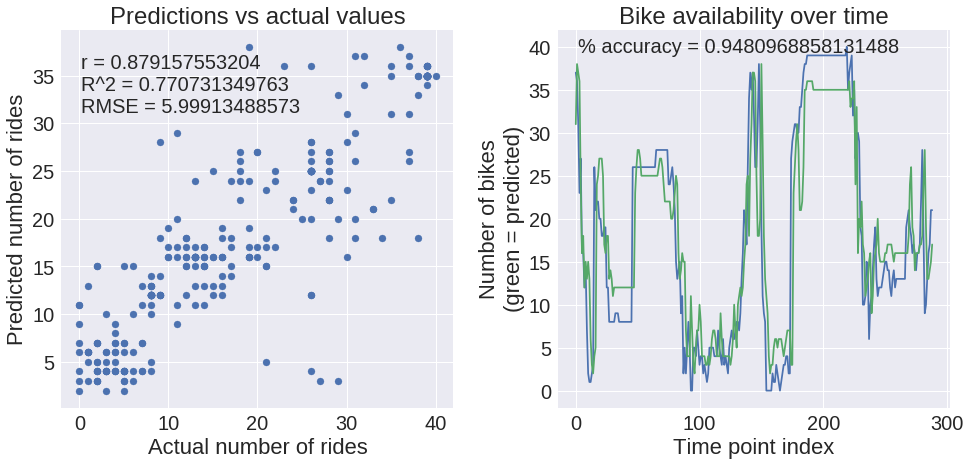

In [33]:
def makeAutoSklearnPrediction(time_to_predict, station, time_difference):
    ## Convert time_to_predict into datetime
    datetime_to_predict = pd.to_datetime(time_to_predict)

    ## Get data for training the model
    ## Make date range to get values for the day a week prior to the query
    ############## USE THIS FOR TESTING UNTIL ENOUGH DATA ARE ACQUIRED, THEN CHANGE FROM 1 DAY TO 7 DAYS PRIOR ####################
    start_time = datetime_to_predict - datetime.timedelta(hours = 24)
    end_time = datetime_to_predict

    ## Make container for data
    train_Xs = []
    train_ys = []
    ## Get data from the dataframe for a station between two times passed in as datetime objects.
    temp_df = pd.DataFrame(df[start_time:end_time][station])
    temp_df.columns = ['y']
            
    ## Make lag features
    number_of_lags = 6
    ## Add lags
    for i in range(1,number_of_lags+1):
        temp_df['lag_'+str(10*i+time_difference)] = temp_df.y.shift(int(i+time_difference/10))
    ## Drop NAs
    temp_df.dropna(inplace = True, axis = 0)
    ## Return X and y values
    temp_Xs = temp_df.drop('y', axis = 1)
    temp_ys = temp_df.y

    ## Get data for making the prediction
    train_Xs = temp_Xs.iloc[:-1, :]
    train_ys = temp_ys.iloc[:-1]
    test_Xs = temp_Xs.iloc[-1, :]
    test_y = temp_ys.iloc[-1]
    
    X_train = np.ascontiguousarray(train_Xs)
    y_train = np.ascontiguousarray(train_ys)
    X_test = np.ascontiguousarray(test_Xs)
    y_test = np.ascontiguousarray(test_y)
    
    features = train_Xs.columns

    ## Make a prediction for the time in question
    prediction = int(np.round(automl.predict(np.array(X_test).reshape(1,-1))))
    ## return the prediction and the actual value
    return prediction, test_y, features

def makeAutoSklearnPlot(preds, actual_vals, feature_names):
    ## Convert the list of arrays each with a single value to a list of values
    lr_variance = r2_score(actual_vals, preds)
    lr_rmse = np.sqrt(mean_squared_error(actual_vals, preds))
    lr_r = sp.stats.pearsonr(actual_vals, preds)[0]

    sns.set(font_scale = 2)
    fig = plt.figure(figsize = [14, 7])
    plt.subplot(1,2,1)
    plt.scatter(actual_vals, preds)
    plt.title('Predictions vs actual values')
    plt.ylabel('Predicted number of rides')
    plt.xlabel('Actual number of rides')
    plt.annotate('r = '+str(sp.stats.pearsonr(actual_vals, preds)[0])+"\nR^2 = "+str(lr_variance)+"\nRMSE = "+str(lr_rmse), xy=(0.05, 0.78), xycoords='axes fraction', size = 20)
    plt.tight_layout()
    plt.subplot(1,2,2)
    plt.plot(actual_vals)
    plt.plot(preds)
    plt.title('Bike availability over time')
    plt.xlabel('Time point index')
    plt.ylabel('Number of bikes\n(green = predicted)')
    plt.annotate('% accuracy = '+str(eval_metric(actual_vals, preds,2)), xy=(0.05, 0.94), xycoords='axes fraction', size = 20)
    plt.tight_layout()

## Give a start time for predictions
start_time_to_predict = '2017-06-12 17:00'
## Give an end time for predictions
end_time_to_predict = '2017-06-14 17:00'
## Make a date range of dates to predict
date_range = pd.date_range(start = pd.to_datetime(start_time_to_predict), end = pd.to_datetime(end_time_to_predict), freq = '10min')
## Make a list of stations for which to make predictions (or just predict all in stations from before)
# stations_to_predict = [31623, 31304, 31520, 31242, 31207, 31204, 31635, 31019, 31919, 31047, 31004]
stations_to_predict = [31623]
## Make various time diffs
time_diffs = [10*i for i in range(1,2)]

## Make containers for relevant values for evaluation
predictions = []
test_ys = []
coefs_list = []
## Make a prediction for various stations
init_time = datetime.datetime.now()
for i, prediction_station in enumerate(stations_to_predict):
    temp_dict = {}
    ## Make a prediction for a range of time diffs
    for prediction_time_diff in time_diffs:
        ## Make a prediction for each time in the date range
        for prediction_time in date_range:
            pred, actual_value, features = makeAutoSklearnPrediction(prediction_time, prediction_station, prediction_time_diff)
            predictions.append(pred)
            test_ys.append(actual_value)
#             coefs_list.append(lr.coef_)
    print('Done with station', i+1, 'of', len(stations_to_predict), '-', datetime.datetime.now() - init_time, 'since start.')

makeAutoSklearnPlot(predictions, test_ys, features)

In [ ]:
## The 1-hour auto-sklearn didn't produce anything better than our linear regression model.
## Overall the simple linear regression works the best for our specific case. It's always nice when things can be kept simple.